In [3]:
from PIL import Image
from pytesseract import pytesseract
import re
import os
import pandas as pd
import numpy as np

In [4]:
file_name =r"C:\Users\ACER\Downloads\Receipt_Item_Price_Scanner-main\Receipt_Item_Price_Scanner-main\receipts\220128_1_foodhall.jpeg"
image_path = os.path.join(r"C:\Users\ACER\Downloads\Receipt_Item_Price_Scanner-main\Receipt_Item_Price_Scanner-main\receipts", file_name)



In [5]:
img = Image.open(image_path)


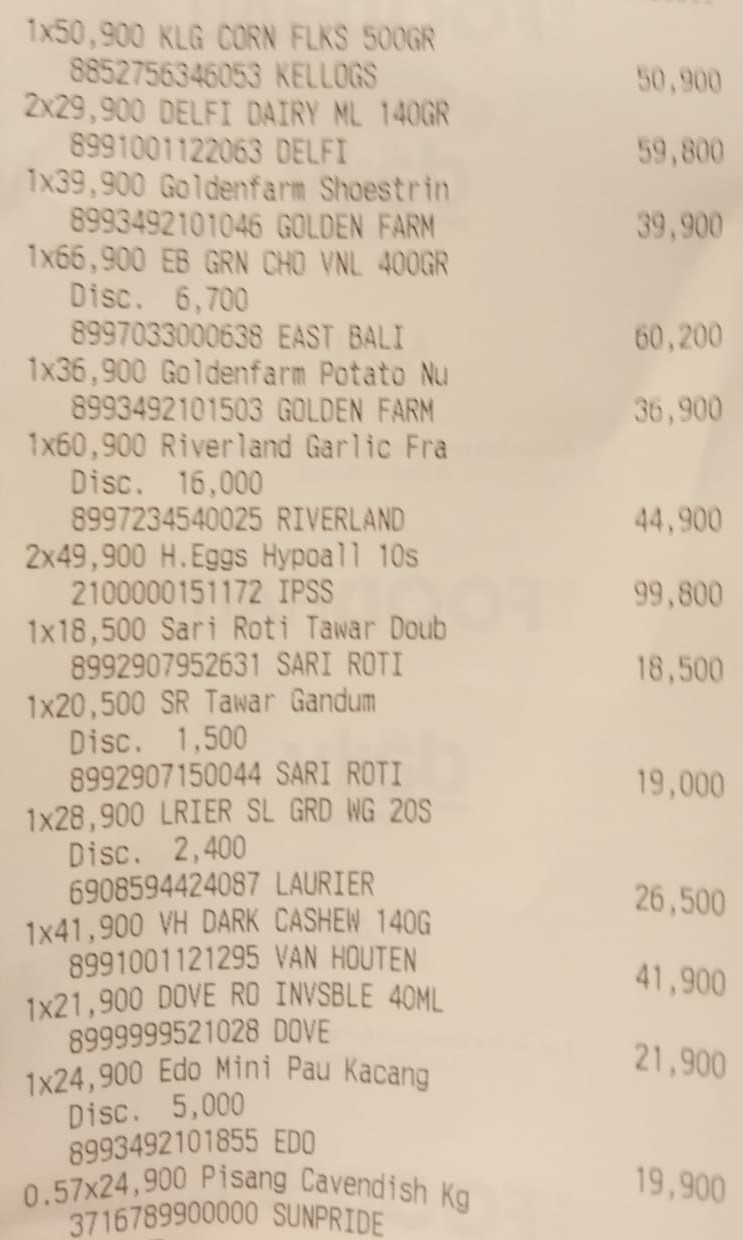

In [6]:
img

In [7]:
pytesseract.tesseract_cmd = "C:\\Program Files\\Tesseract-OCR\\tesseract.exe"


In [8]:
text = pytesseract.image_to_string(img).replace('X','x').replace('*','x').replace('%','x')


In [9]:

text 

'1x50, 900 KLG OORN FLAS S00GR\n8852756346053 KELLOGS\n2x23,900 DELFI DAIRY NL 140GR\n8391001122063 DELFI\n1x39, 900 Goldenfarm Shoestrin\n8993492101046 GOLDEN FARN\n1x66,900 EB GRN CHO VNL 4006R\nDisc. 6,700\n8997033000638 EAST BALI\n1x36,900 Goldenfarm Potato Nu\n8993492101503 GOLDEN FARM\n1x60,900 Riverland Garlic Fra\nDisc. 16,000\n8997234540025 RIVERLAND\n2x49,900 H.Eggs Hypoal] 10s\n2100000151172 IPSS\n1x18,500 Sari Roti Tawar Doub\n8992907952631 SARI ROTI\n1x20,500 SR Tawar Gandum\nDisc. 1,500\n8992907150044 SARI ROTI\n1x28,900 LRIER SL GRD WG 20S\nDisc. 2,400\n6908594424087 LAURIER\n1x41,900 VH DARK CASHEW 1406\n8991001121295 VAN HOUTEN\n4x21,900 DOVE RO INVSBLE 40ML\n521028 DOVE\n1x24,900 Edo Mini Pau Kacang\n\n$c. 9:\n92101855 EDO\n\n(57x24, 900 Pisang Cavendish K\n0,97x,6789900000 SUNPRIDE x x8\n\n$0,900\n59, 800\n39,900\n\n60,200\n36,900\n\n44,900\n99,800\n18,500\n\n19,000\n\n26,500\n41,900\n\n21,900\n\n19,900\n'

In [10]:
# check if a string is a float
def is_number(string):
    try:
        float(string) or int(string)
        return True
    except ValueError:
        pass

# extract the necessary information on items, amounts, and prices from text object and put it into a dataframe
def convert_text_to_dataframe_foodhall(text):
    splitted_text = text.split('\n')
    
    item = []
    amount_str = []
    price_total = []
    price_per_item_str = []
    text_lines = []
    
    # create lists with required information
    for line in splitted_text:
        if re.findall('\d{1,}x\d{1,}', line):

            start_index = [index for index, string in enumerate(line) if string.isdigit()]
            middle_index = [index for index, string in enumerate(line) if string == 'x']
            end_index = [index for index, string in enumerate(line) if string ==' ']

            text_lines.append(line)

            if start_index != [] and middle_index != [] and end_index != []:
                if start_index[0] > end_index[0]:
                    item.append(line[end_index[1]:].strip())
                    amount_str.append(line[start_index[0]:middle_index[0]])
                    price_per_item_str.append(line[middle_index[0]+1:end_index[1]].replace(' ', '').replace(',', ''))
                elif line[end_index[0]-1] == ',' or line[end_index[0]+1] == ',':
                    item.append(line[end_index[1]:].strip())
                    amount_str.append(line[start_index[0]:middle_index[0]])
                    price_per_item_str.append(line[middle_index[0]+1:end_index[1]].replace(' ', '').replace(',', ''))
                else:
                    item.append(line[end_index[0]:].strip())
                    amount_str.append(line[start_index[0]:middle_index[0]])
                    price_per_item_str.append(line[middle_index[0]+1:end_index[0]].replace(' ', '').replace(',', ''))

    # convert to correct format and calculate price per single item
    amount = []
    price_per_item = []

    for entry in amount_str:
        if is_number(entry.replace(',','.')):
            amount.append(float(entry.replace(',','.')))

    for entry in price_per_item_str:
        if is_number(entry.replace(',','.')):
            price_per_item.append(float(entry.replace(',','.')))
        
    i = 0
    for entry in price_per_item:
        price_total.append(round(float(price_per_item[i])*float(amount[i]), 2))
        i += 1       
        
    # create pandas data frame
    df = pd.DataFrame(list(zip(item, amount, price_total, price_per_item, text_lines)), 
                      columns = ['Item', 'Amount', 'Total Price', 'Price per Item', 'Source Text']
                     )      
    return df

# extract the necessary information on items, amounts, and prices from text object and put it into a dataframe
def convert_text_to_dataframe_family_mart(text):
    splitted_text = text.split('\n')

    text_lines = []
    i = 0
    for entry in splitted_text:
        if i % 2 == 1 and entry != '':
            text_lines.append(entry)
        i += 1

    item = []
    i = 0
    for entry in splitted_text:
        if i % 2 == 0 and entry != '':
            item.append(entry)
        i += 1

    price_per_item = []
    for entry in text_lines:
        if re.findall('[ \d]{1,}[x]{1,}[\d ]{1,}', entry):
            price_per_item.append(float(entry.split()[0].replace(',','')))

    amount = []
    for entry in text_lines:
        if re.findall('[ \d]{1,}[x]{1,}[\d ]{1,}', entry):
            amount.append(float(entry.split()[2].strip()))

    price_total = [amount[i]*price_per_item[i] for i in range(len(amount))]
    
    # create pandas data frame
    df = pd.DataFrame(list(zip(item, amount, price_total, price_per_item, text_lines)), 
                      columns = ['Item', 'Amount', 'Total Price', 'Price per Item', 'Source Text']
                     )
    
    return df

In [11]:
splitted_text = text.split('\n')

item = []
amount_str = []
price_total = []
price_per_item_str = []
text_lines = []

# create lists with required information
for line in splitted_text:
    if re.findall('\d{1,}x\d{1,}', line):

        start_index = [index for index, string in enumerate(line) if string.isdigit()]
        middle_index = [index for index, string in enumerate(line) if string == 'x']
        end_index = [index for index, string in enumerate(line) if string ==' ']

        text_lines.append(line)
    
        if start_index != [] and middle_index != [] and end_index != []:
            if start_index[0] > end_index[0]:
                item.append(line[end_index[1]:].strip())
                amount_str.append(line[start_index[0]:middle_index[0]])
                price_per_item_str.append(line[middle_index[0]+1:end_index[1]].replace(' ', '').replace(',', ''))
            elif line[end_index[0]-1] == ',' or line[end_index[0]+1] == ',':
                item.append(line[end_index[1]:].strip())
                amount_str.append(line[start_index[0]:middle_index[0]])
                price_per_item_str.append(line[middle_index[0]+1:end_index[1]].replace(' ', '').replace(',', ''))
            else:
                item.append(line[end_index[0]:].strip())
                amount_str.append(line[start_index[0]:middle_index[0]])
                price_per_item_str.append(line[middle_index[0]+1:end_index[0]].replace(' ', '').replace(',', ''))

# convert to correct format and calculate price per single item
amount = []
price_per_item = []

for entry in amount_str:
    amount.append(float(entry.replace(',','.')))

for entry in price_per_item_str:
    price_per_item.append(float(entry.replace(',','.')))
    
i = 0

for entry in price_per_item:
    price_total.append(round(float(price_per_item[i])*float(amount[i]), 2))
    i += 1       

# create pandas data frame
df = pd.DataFrame(list(zip(item, amount, price_total, price_per_item, text_lines)), 
                  columns = ['Item', 'Amount', 'Total Price', 'Price per Item', 'Source Text']
                 )
df

,Item,Amount,Total Price,Price per Item,Source Text
0,KLG OORN FLAS S00GR,1.0,50900.0,50900.0,"1x50, 900 KLG OORN FLAS S00GR"
1,DELFI DAIRY NL 140GR,2.0,47800.0,23900.0,"2x23,900 DELFI DAIRY NL 140GR"
2,Goldenfarm Shoestrin,1.0,39900.0,39900.0,"1x39, 900 Goldenfarm Shoestrin"
3,EB GRN CHO VNL 4006R,1.0,66900.0,66900.0,"1x66,900 EB GRN CHO VNL 4006R"
4,Goldenfarm Potato Nu,1.0,36900.0,36900.0,"1x36,900 Goldenfarm Potato Nu"
5,Riverland Garlic Fra,1.0,60900.0,60900.0,"1x60,900 Riverland Garlic Fra"
6,H.Eggs Hypoal] 10s,2.0,99800.0,49900.0,"2x49,900 H.Eggs Hypoal] 10s"
7,Sari Roti Tawar Doub,1.0,18500.0,18500.0,"1x18,500 Sari Roti Tawar Doub"
8,SR Tawar Gandum,1.0,20500.0,20500.0,"1x20,500 SR Tawar Gandum"
9,LRIER SL GRD WG 20S,1.0,28900.0,28900.0,"1x28,900 LRIER SL GRD WG 20S"


In [12]:
df.to_excel("output1.xlsx")

In [12]:
splitted_text = text.split('\n')

text_lines = []
i = 0
for entry in splitted_text:
    if i % 2 == 1 and entry != '':
        text_lines.append(entry)
    i += 1

item = []
i = 0
for entry in splitted_text:
    if i % 2 == 0 and entry != '':
        item.append(entry)
    i += 1
    
print(text_lines)
print(item)

price_per_item = []
for entry in text_lines:
    if re.findall('[ \d]{1,}[x]{1,}[\d ]{1,}', entry):
        price_per_item.append(float(entry.split()[0].replace(',','')))

amount = []
for entry in text_lines:
    if re.findall('[ \d]{1,}[x]{1,}[\d ]{1,}', entry):
        amount.append(float(entry.split()[2].strip()))

price_total = [amount[i]*price_per_item[i] for i in range(len(amount))]

# create pandas data frame
df = pd.DataFrame(list(zip(item, amount, price_total, price_per_item, text_lines)), 
                  columns = ['Item', 'Amount', 'Total Price', 'Price per Item', 'Source Text']
                 )

df

['8852756346053 KELLOGS', '8391001122063 DELFI', '8993492101046 GOLDEN FARN', 'Disc. 6,700', '1x36,900 Goldenfarm Potato Nu', '1x60,900 Riverland Garlic Fra', '8997234540025 RIVERLAND', '2100000151172 IPSS', '8992907952631 SARI ROTI', 'Disc. 1,500', '1x28,900 LRIER SL GRD WG 20S', '6908594424087 LAURIER', '8991001121295 VAN HOUTEN', '521028 DOVE', '92101855 EDO', '(57x24, 900 Pisang Cavendish K', '59, 800', '36,900', '44,900', '18,500', '19,000', '26,500']
['1x50, 900 KLG OORN FLAS S00GR', '2x23,900 DELFI DAIRY NL 140GR', '1x39, 900 Goldenfarm Shoestrin', '1x66,900 EB GRN CHO VNL 4006R', '8997033000638 EAST BALI', '8993492101503 GOLDEN FARM', 'Disc. 16,000', '2x49,900 H.Eggs Hypoal] 10s', '1x18,500 Sari Roti Tawar Doub', '1x20,500 SR Tawar Gandum', '8992907150044 SARI ROTI', 'Disc. 2,400', '1x41,900 VH DARK CASHEW 1406', '4x21,900 DOVE RO INVSBLE 40ML', '1x24,900 Edo Mini Pau Kacang', '$c. 9:', '0,97x,6789900000 SUNPRIDE x x8', '$0,900', '39,900', '60,200', '99,800', '41,900', '21,900'

ValueError: could not convert string to float: '1x36900'

In [ ]:
def create_excel_from_dataframes(df):
    excel_name = r'C:\Users\p\Price_Comparison.xlsx'
    sheet_name = 'sheet_1'
    
    # read source excel file into first dataframe
    df_source = pd.DataFrame(pd.read_excel(excel_name, sheet_name=sheet_name))
    
    # combine first dataframe with new dataframe
    df_final = df_source.append(df, sort=False)
    
    # creater writer object to write in file
    writer = pd.ExcelWriter(excel_name)
    df_final.to_excel(writer, sheet_name=sheet_name, index=False)

    # set the column width in excel to autofit the content
    for column in df:
        column_length = max(df[column].astype(str).map(len).max(), len(column))
        column_index = df.columns.get_loc(column)
        writer.sheets[sheet_name].set_column(column_index, column_index, column_length)

    writer.save()